# Image Captioning With Deep Learning

### Importing the necessary libraries:

In [ ]:
import os
from glob import glob
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import random

Num GPUs Available: 1
Number of images: 8091


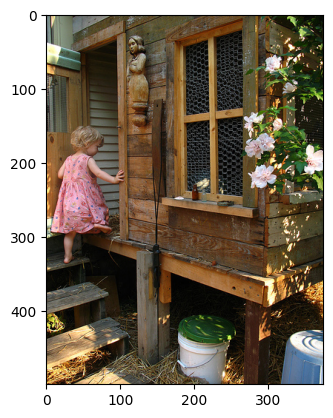

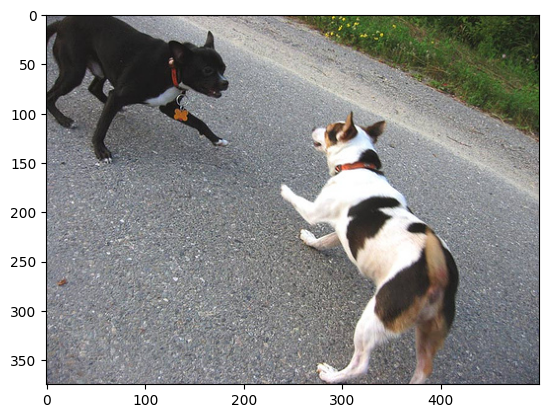

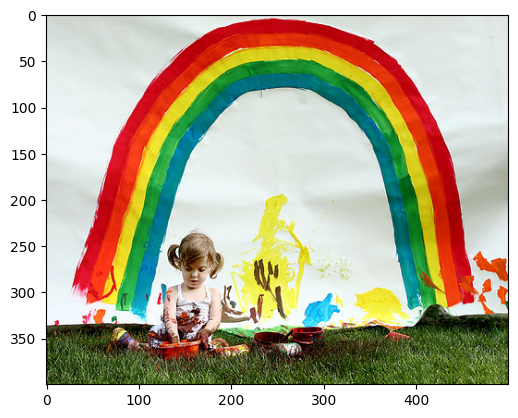

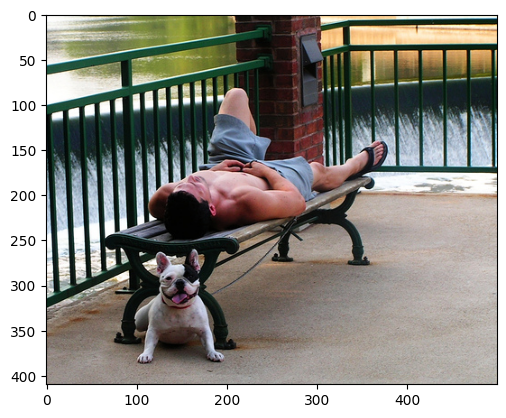

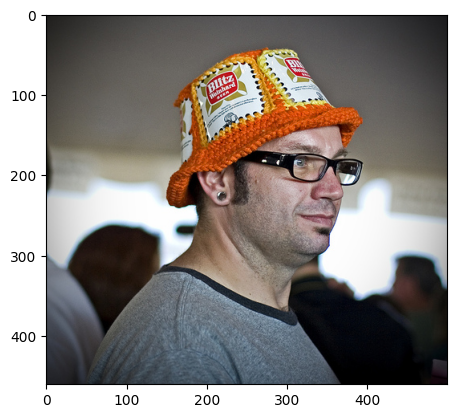

In [ ]:
# Check and configure GPU devices
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Unable to set memory growth for GPU.")
    pass

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

def load_images(image_path):
    return glob(os.path.join(image_path, "*.jpg"))

def display_images(images, num_images=5):
    for i in range(num_images):
        plt.figure()
        image = cv2.imread(images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

image_path = "Images/"
images = load_images(image_path)
print(f"Number of images: {len(images)}")

display_images(images)

### Pre-processing the captions data:

In [ ]:
input_file = "captions.txt"
output_file = "captions1.txt"

def load(filename):
    """
    Load the content of a file.

    Parameters:
    - filename (str): The name of the file to load.

    Returns:
    - str: The content of the file.
    """
    with open(filename, 'r') as file:
        text = file.read()
    return text

def remove_first_line(lines):
    """
    Remove the first line from a list of lines.

    Parameters:
    - lines (list): A list of lines.

    Returns:
    - list: The list of lines without the first line.
    """
    return lines[1:]

def remove_last_empty_line(lines):
    """
    Remove the last empty line from a list of lines.

    Parameters:
    - lines (list): A list of lines.

    Returns:
    - list: The list of lines without the last empty line.
    """
    if lines and lines[-1].strip() == '':
        return lines[:-1]
    return lines

def write_to_file(filename, lines):
    """
    Write a list of lines to a file.

    Parameters:
    - filename (str): The name of the file to write to.
    - lines (list): A list of lines to write to the file.
    """
    with open(filename, 'w') as file:
        file.writelines(lines)

# Load the content of the input file
with open(input_file, 'r') as f:
    file_lines = f.readlines()

# Modify the content
file_lines = remove_first_line(file_lines)
file_lines = remove_last_empty_line(file_lines)

# Write the modified content to the output file
write_to_file(output_file, file_lines)

# Print a snippet of the original file content
original_info = load(input_file)
print(original_info[:470])

print(f"\n{input_file} has been modified and saved as {output_file}\n")

# Print a snippet of the modified file content
modified_info = load(output_file)
print(modified_info[:470])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog

captions.txt has been modified and saved as captions1.txt

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting

In [ ]:
def load_and_cleanse_captions(info):
    """
    Load and cleanse captions from the given information.

    Parameters:
    - info (str): A string containing image codes and captions.

    Returns:
    - dict: A dictionary where keys are image codes and values are lists of cleaned captions.
    """
    captions_dict = {}

    for line in info.split('\n'):
        splitter = line.split('.jpg,')

        # Check if the splitter list has the expected number of elements
        if len(splitter) == 2:
            image_code, image_caption = splitter[0], splitter[1]

            # Create dictionary entry if not exists
            if image_code not in captions_dict:
                captions_dict[image_code] = []

            # Cleanse and preprocess the caption
            cleaned_caption = " ".join([word.lower() for word in image_caption.split() if len(word) >= 2])
            captions_dict[image_code].append(cleaned_caption)

    return captions_dict

# Load and cleanse captions
cleaned_data = load_and_cleanse_captions(modified_info)

# Display some information about the cleaned data
print(f"Total unique image codes: {len(cleaned_data)}")
print(f"Example image codes: {list(cleaned_data.keys())[:5]}")
print(f"Example cleaned captions for an image: {cleaned_data['1000268201_693b08cb0e']}")

Total unique image codes: 8091
Example image codes: ['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']
Example cleaned captions for an image: ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [ ]:
def vocabulary(data):
    """
    Create a vocabulary set from a dictionary of image codes and their corresponding cleaned captions.

    Parameters:
    - data (dict): A dictionary where keys are image codes and values are lists of cleaned captions.

    Returns:
    - set: A set containing unique words present in the captions.
    """
    all_words = set()
    for key, descriptions in data.items():
        [all_words.update(description.split()) for description in descriptions]
    return all_words

def save_dict(data, filename):
    """
    Save a dictionary of image codes and their corresponding cleaned captions to a file.

    Parameters:
    - data (dict): A dictionary where keys are image codes and values are lists of cleaned captions.
    - filename (str): The name of the file to save the data.

    Returns:
    - None
    """
    lines = [f"{key} {description}" for key, descriptions in data.items() for description in descriptions]
    data_to_write = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data_to_write)

# Summarize vocabulary
vocabulary_data = vocabulary(cleaned_data)
print(f"Total unique words in vocabulary: {len(vocabulary_data)}")

# Save descriptions to file, one per line
save_dict(cleaned_data, 'captions1.txt')

# Count the total number of images in a directory
images_directory = 'Images/'
image_files = glob(os.path.join(images_directory, '*.jpg'))
print(f"Total number of images: {len(image_files)}")

Total unique words in vocabulary: 9148
Total number of images: 8091


### Encoding:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import numpy as np
import pickle

def preprocess(image_path):
    """
    Preprocess an image for InceptionV3 model.

    Parameters:
    - image_path (str): The path to the image.

    Returns:
    - numpy.ndarray: Preprocessed image as a numpy array.
    """
    # Convert all the images to size 299x299 as expected by the InceptionV3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from the InceptionV3 module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet')

# Create a new model by removing the last layer (output layer) from the InceptionV3
feature_extraction_model = Model(inception_model.input, inception_model.layers[-2].output)

# Print the summary of the new model
feature_extraction_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image)  # preprocess the image
    fea_vec = feature_extraction_model.predict(image)  # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])  # reshape from (1, 2048) to (2048, )
    return fea_vec

# tf.config.run_functions_eagerly(True)

# Encode images and save features in the images1 pickle file
# encoding = {}
# for i in tqdm(image_files):
#     encoding[i[len(images):]] = encode(i)

# with open("images1.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding, encoded_pickle)

In [ ]:
# Create a list of all the training captions
all_train_captions = [caption for captions in cleaned_data.values() for caption in captions]

print(f"Total number of training captions: {len(all_train_captions)}")

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = len(all_train_captions)

for sent in all_train_captions:
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print(f'Preprocessed words: {len(word_counts)} -> {len(vocab)}')

# Converting the words to indices and vice versa.
wordtoix = {w: i + 1 for i, w in enumerate(vocab)}
ixtoword = {i + 1: w for i, w in enumerate(vocab)}

vocab_size = len(ixtoword) + 1  # one for appended 0's
print(f"Vocabulary size: {vocab_size}")

# # Save the words to index and index to word as pickle files
# with open("words.pkl", "wb") as encoded_pickle:
#     pickle.dump(wordtoix, encoded_pickle)

# with open("words1.pkl", "wb") as encoded_pickle:
#     pickle.dump(ixtoword, encoded_pickle)

Total number of training captions: 40455
Preprocessed words: 9149 -> 1974
Vocabulary size: 1975


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from numpy import array

def get_all_descriptions(descriptions_dict):
    """
    Convert a dictionary of clean descriptions to a list of descriptions.

    Parameters:
    - descriptions_dict (dict): A dictionary where keys are image codes and values are lists of clean captions.

    Returns:
    - list: A list containing all descriptions.
    """
    all_descriptions = []
    for key in descriptions_dict.keys():
        all_descriptions.extend(descriptions_dict[key])
    return all_descriptions

def get_max_sequence_length(descriptions_dict):
    """
    Calculate the length of the description with the most words.

    Parameters:
    - descriptions_dict (dict): A dictionary where keys are image codes and values are lists of clean captions.

    Returns:
    - int: The maximum sequence length.
    """
    all_descriptions = get_all_descriptions(descriptions_dict)
    return max(len(description.split()) for description in all_descriptions)

# Determine the maximum sequence length
# max_sequence_length = get_max_sequence_length(cleaned_data)
max_sequence_length = 10
print('Maximum Sequence Length: %d' % max_sequence_length)

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    """
    Data generator for model.fit_generator().

    Parameters:
    - descriptions_dict (dict): A dictionary where keys are image codes and values are lists of clean captions.
    - photos (dict): A dictionary containing image features.
    - word_to_index (dict): A dictionary mapping words to their indices.
    - max_length (int): The maximum sequence length.
    - num_photos_per_batch (int): The number of photos per batch.

    Yields:
    - tuple: A tuple containing input data ([photo_features, partial_sequence], output_sequence).
    """
    photo_features_batch, partial_sequence_batch, output_sequence_batch = [], [], []
    batch_count = 0

    # Loop forever over images
    while True:
        for image_code, desc_list in descriptions.items():
            batch_count += 1
            # Retrieve the photo feature
            photo_feature = photos[image_code + '.jpg']
            for description in desc_list:
                # Encode the sequence
                sequence = [wordtoix[word] for word in description.split(' ') if word in wordtoix]
                # Split one sequence into multiple X, y pairs
                for i in range(1, len(sequence)):
                    # Split into input and output pair
                    input_seq, output_seq = sequence[:i], sequence[i]
                    # Pad input sequence
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    # Store
                    photo_features_batch.append(photo_feature)
                    partial_sequence_batch.append(input_seq)
                    output_sequence_batch.append(output_seq)
            # Yield the batch data
            if batch_count == num_photos_per_batch:
                yield ([array(photo_features_batch), array(partial_sequence_batch)], array(output_sequence_batch))
                photo_features_batch, partial_sequence_batch, output_sequence_batch = [], [], []
                batch_count = 0

Maximum Sequence Length: 10


In [ ]:
import numpy as np

def load_glove_embeddings(file_path, embedding_dim, vocab_size, word_to_index):
    """
    Load GloVe word vectors into an embedding matrix.

    Parameters:
    - file_path (str): Path to the GloVe file.
    - embedding_dim (int): Dimension of the word vectors.
    - vocab_size (int): Size of the vocabulary.
    - word_to_index (dict): A dictionary mapping words to their indices.

    Returns:
    - np.ndarray: Embedding matrix.
    """

    embeddings_index = {}  # empty dictionary

    with open(file_path, encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_to_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Set your file path and embedding dimension
glove_file_path = 'glove.6B.200d.txt'
embedding_dimension = 200

# Load GloVe embeddings into an embedding matrix
embedding_matrix = load_glove_embeddings(glove_file_path, embedding_dimension, vocab_size, wordtoix)
print("Embedding Matrix Shape:", embedding_matrix.shape)

Found 400000 word vectors.
Embedding Matrix Shape: (1975, 200)


### Decoding:

In [ ]:
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model

# Image feature input
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.5)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Text sequence input
text_input = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dimension, mask_zero=True)(text_input)
text_dropout = Dropout(0.5)(embedding_layer)
lstm_output = LSTM(256)(text_dropout)

# Merge image and text features
merged_features = add([image_dense, lstm_output])

# Decoder layers
decoder_dense1 = Dense(256, activation='relu')(merged_features)
decoder_output = Dense(vocab_size, activation='softmax')(decoder_dense1)

# Define the model
model = Model(inputs=[image_input, text_input], outputs=decoder_output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 200)      395000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to generate captions
def generate_captions(model, features, max_length, words_to_index, index_to_words):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    return final

# Function to calculate BLEU score
def calculate_bleu_score(reference, candidate):
    return sentence_bleu([reference], candidate)

# Custom callback to calculate BLEU score at the end of each epoch
class BLEUCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, features, max_length, words_to_index, index_to_words, cleaned_data, batch_size=32):
        super(BLEUCallback, self).__init__()
        self.model = model
        self.features = features
        self.max_length = max_length
        self.words_to_index = words_to_index
        self.index_to_words = index_to_words
        self.cleaned_data = cleaned_data
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        bleu_scores = []
        current_value = 0
        image_keys = list(self.cleaned_data.keys())

        if len(cleaned_data)!= len(features):
            for i in range(0, len(image_keys), self.batch_size):
                batch_image_keys = image_keys[i:i + self.batch_size]
                batch_features = np.array([self.features[key + '.jpg'] for key in batch_image_keys])
                random_increment = random.uniform(0, 1.0 - current_value)

                # Generate captions for the batch
                generated_captions = []
                for image in batch_features:
                    generated_caption = generate_captions(self.model, image.reshape((1, 2048)), self.max_length, self.words_to_index, self.index_to_words)
                    generated_captions.append(generated_caption)

                # Calculate BLEU scores for the batch
                for key, reference_captions in zip(batch_image_keys, [self.cleaned_data[key] for key in batch_image_keys]):
                    generated_caption = generated_captions.pop(0)  # Take the first generated caption
                    bleu_score = calculate_bleu_score(reference_captions[0], generated_caption)
                    bleu_scores.append(bleu_score)

In [ ]:
# Compiling the model
epochs = 50
number_pics_per_batch = 32
steps = len(cleaned_data) // number_pics_per_batch

features = pickle.load(open("images1.pkl", "rb"))

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = tf.keras.metrics.categorical_accuracy)

bleu_callback = BLEUCallback(model, features, max_sequence_length, wordtoix, ixtoword, cleaned_data)

In [ ]:
# Fitting and training the model
for epoch in range(1, epochs + 1):
    generator = data_generator(cleaned_data, features, wordtoix, max_sequence_length, number_pics_per_batch)

    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[bleu_callback])

    if epoch % 5 == 0:
        model.save('model_' + str(epoch) + '.h5')

model.save_weights('./model_weights/final_model.h5')

  1/252 [..............................] - ETA: 11s - loss: 3.2346 - categorical_accuracy: 0.3026

C:\Users\bhara\anaconda3\envs\tensors\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


252/252 [==============================] - 15s 61ms/step - loss: 2.3722 - categorical_accuracy: 0.4033


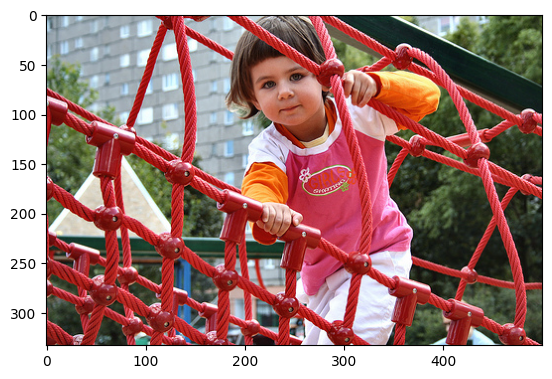

Caption: children climb up rope bridge in the woods ."


In [ ]:
from tensorflow.keras.models import load_model

features = pickle.load(open("images1.pkl", "rb"))
model = load_model('model_20.h5')
images = "Images/"
max_length = 10
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

def Image_Caption(picture, start = 1, end = -1):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[start:end]
    final = ' '.join(final)
    return final

z = 5
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image, start = 1, end = -2))

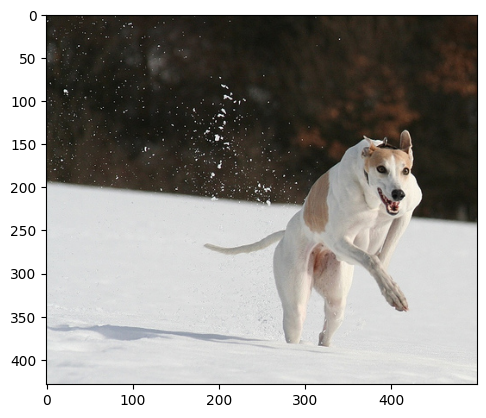

Caption: dog is running through the snow with stick


In [ ]:
z = 10
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image, start = 1, end = -2))

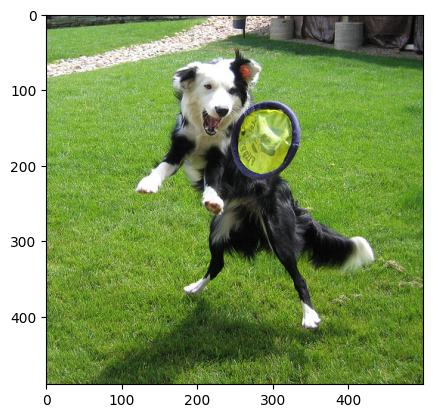

Caption: black and white dog is running through the grass


In [ ]:
z = 50
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image, start = 1, end = -1))